# Step 1: Environment Setup & Data Loading

In [19]:
# Create directory for images if it doesn't exist
import os
os.makedirs('../images', exist_ok=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

# Dataset Loading
df = pd.read_csv('../data/marketing_campaign.csv', sep='\t')
display(df.head())

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Step 2: Data Preprocessing & Feature Engineering

In [20]:
# Replacing missing values in Income based on Education
df['Income'] = df['Income'].fillna(df.groupby('Education')['Income'].transform('mean'))

# Removing outliers (Age > 100, Income > 400k)
df = df[df['Year_Birth'] > 1940]
df = df[df['Income'] < 400000]

# Feature Engineering: Family and household demographics
df['Kids'] = df['Kidhome'] + df['Teenhome'] 
df['Partner'] = df['Marital_Status'].isin(['Together','Married']).astype(int)
df['Household'] = df['Kids'] + df['Partner'] + 1 
df['IncomePerCapita'] = df['Income'] / df['Household']

# Feature Engineering: Client tenure in months
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
latest_date = df['Dt_Customer'].max()
df['Tenure_Months'] = (latest_date.year - df['Dt_Customer'].dt.year) * 12 + (latest_date.month - df['Dt_Customer'].dt.month)

# Feature Engineering: Financials & Campaign Responses
df['MntAllProducts'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Age'] = 2014 - df['Year_Birth']
df['AcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']

# Mapping Education to Numeric values
education_map = {'Basic': 1, '2n Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5}
df['Education_Numeric'] = df['Education'].map(education_map)

# Dropping unnecessary columns
columns_to_drop = ['ID','Year_Birth','Education','Marital_Status','Kidhome','Teenhome','Dt_Customer','Z_CostContact','Z_Revenue']
df = df.drop(columns_to_drop, axis=1).reset_index(drop=True)

# Dataset scaling for clustering
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Step 3: Feature Selection for Clustering & K-Means Evaluation

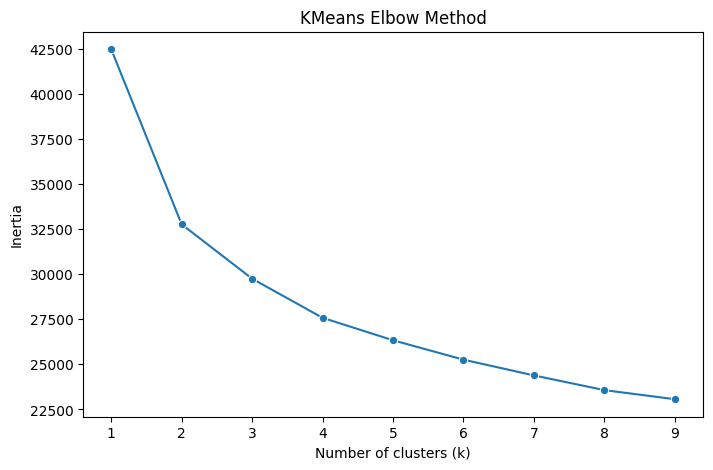

In [21]:
# Selecting features for clustering
feats_for_clustering = [
    'IncomePerCapita', 'Kids', 'Partner', 'Age', 'Education_Numeric', 'Complain', 
    'Tenure_Months', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
    'NumWebPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 
    'AcceptedCmp', 'NumDealsPurchases']
df_selected = df_scaled[feats_for_clustering]

# KMeans Elbow Method
elbow = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_selected)
    elbow[k] = kmeans.inertia_

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(elbow.keys()), y=list(elbow.values()), marker='o')
plt.title("KMeans Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.savefig('../images/kmeans_elbow.png', bbox_inches='tight') 
plt.show()

# Step 4: Final Segmentation (K-Means k=4) and Profiling

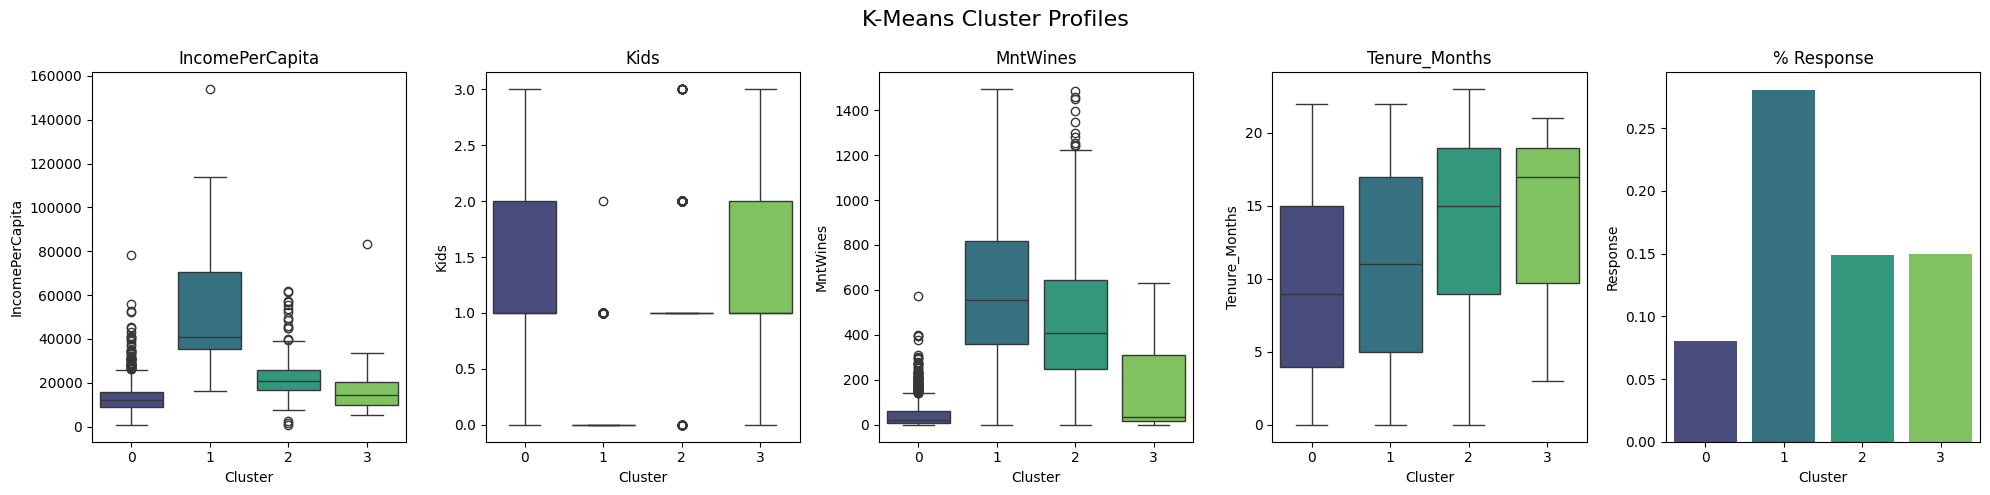

In [22]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["Cluster_KMeans"] = kmeans.fit_predict(df_selected)

# Visualizing Cluster Profiles
feats_to_plot = ['IncomePerCapita', 'Kids', 'MntWines', 'Tenure_Months', 'Response']
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
fig.suptitle('K-Means Cluster Profiles', fontsize=16)

for i, col in enumerate(feats_to_plot):
    ax = axes[i]
    if col == 'Response':
        sns.barplot(x=df['Cluster_KMeans'], y=df[col], palette='viridis', ax=ax, errorbar=None)
        ax.set_title(f'% {col}')
    else:
        sns.boxplot(x=df['Cluster_KMeans'], y=df[col], palette='viridis', ax=ax)
        ax.set_title(f'{col}')
    ax.set_xlabel('Cluster')

plt.tight_layout()
plt.savefig('../images/cluster_boxplots.png', bbox_inches='tight') 
plt.show()

# Data Prep for Prediction Phase
df_model = pd.get_dummies(df, columns=['Cluster_KMeans'], prefix='Cluster', drop_first=True)

# Step 5: Setup for Prediction (Modeling)

In [23]:
# Evaluation helper function with saving plot capability
def evaluate_model(model, X_test, y_test, model_name, filename):
    y_pred = model.predict(X_test)
    print(f"--- REPORT: {model_name} ---")
    print(classification_report(y_test, y_pred))

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12, "weight": "bold"})
    plt.title(f'{model_name}\nPrec: {prec:.2f} | Rec: {rec:.2f} | F1: {f1:.2f}', fontsize=11)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(f'../images/{filename}.png', bbox_inches='tight') 
    plt.show()

# Train/test split
X = df_model.drop(["Response", 'AcceptedCmp'], axis=1)
y = df_model['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Random Forest (Optimized for Precision)

--- REPORT: Random Forest (High Precision) ---
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       571
           1       0.80      0.39      0.52       100

    accuracy                           0.89       671
   macro avg       0.85      0.69      0.73       671
weighted avg       0.89      0.89      0.88       671



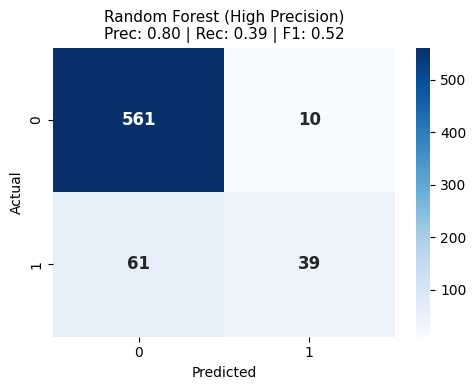

In [27]:
# Tuning RF for High Precision (Cost-Saving Strategy)
rf_precision = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt']
    }

grid_rf = GridSearchCV(estimator=rf_precision, param_grid=param_grid_rf, cv=5, scoring='precision', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

evaluate_model(best_rf, X_test, y_test, "Random Forest (High Precision)", "rf_confusion_matrix")

# Step 7: XGBoost (Optimized for F1-Score) & Feature Importance

--- REPORT: XGBoost (Balanced/F1) ---
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       571
           1       0.57      0.69      0.62       100

    accuracy                           0.88       671
   macro avg       0.76      0.80      0.78       671
weighted avg       0.89      0.88      0.88       671



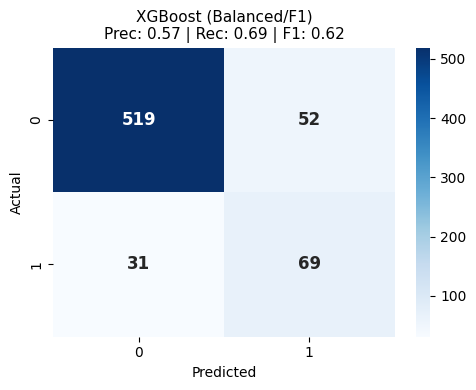

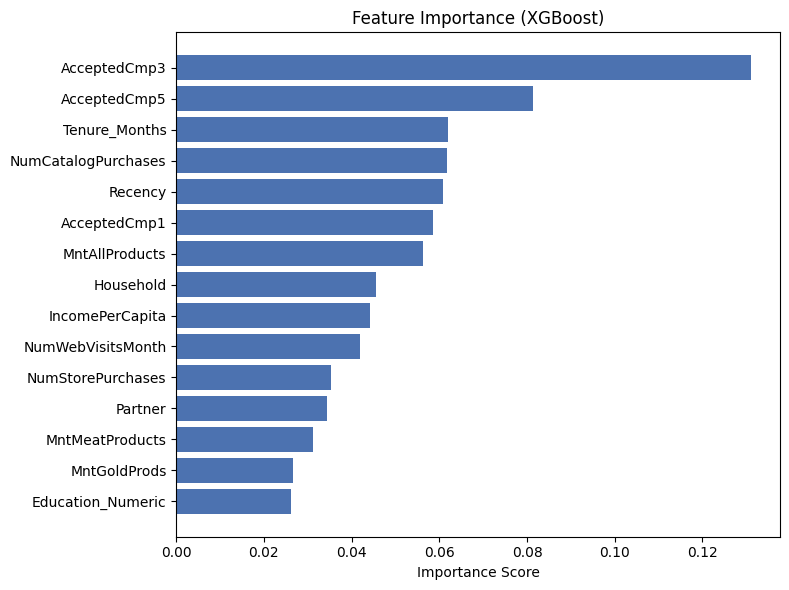

In [26]:
# Tuning XGBoost for Growth Strategy
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
param_grid_xgb = {
    'n_estimators': [200],
    'learning_rate': [0.1],
    'max_depth': [3, 5],
    'scale_pos_weight': [ratio]
    }

grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

evaluate_model(best_xgb, X_test, y_test, "XGBoost (Balanced/F1)", "xgb_confusion_matrix")

# Feature Importance Plot
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(8, 6))
plt.title("Feature Importance (XGBoost)")
plt.barh(range(top_n), importances[indices[:top_n]][::-1], align="center", color='#4c72b0')
plt.yticks(range(top_n), [X.columns[i] for i in indices[:top_n]][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig('../images/feature_importance.png', bbox_inches='tight')
plt.show()